# Titanic (Kaggle) — **Meu caderno explicadão em 1ª pessoa** 🚢🧠

> **Contexto:** eu já mando bem em Python, mas estou aprendendo ML do zero.  
> Aqui eu me explico, passo a passo, o que estou fazendo, por que, e como checo se deu certo.  
> No final eu gero `submission.csv` e salvo um modelo pronto para reuso.

**Fluxo que vou seguir:** preparar pastas → carregar dados → EDA e *sanity checks* → criar *features* → pré-processar → comparar modelos → buscar hiperparâmetros → interpretar → avaliar de verdade → gerar *submission*.

## 0) Setup de diretórios, seeds e importações
Eu quero que tudo seja reprodutível e organizado em pastas previsíveis.

In [5]:
# Importo libs padrão: manipulação de caminhos/arquivos e ciência de dados
from pathlib import Path                   # caminho de arquivo de forma robusta
import numpy as np                         # arrays/matemática rápida
import pandas as pd                        # DataFrames (tabelas)
import matplotlib.pyplot as plt            # gráficos (vou usar SEM seaborn aqui)

# Defino uma seed global para dar reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Defino a raiz do projeto (ajuste se estiver rodando de outro lugar)
BASE_DIR = Path(r"C:\Projetos\machine-learning-projects\titanic-survival-prediction")

# Defino subpastas que vou usar ao longo do fluxo
DATA_RAW = BASE_DIR / "data" / "raw"              # onde tenho train.csv e test.csv
DATA_INTERIM = BASE_DIR / "data" / "interim"      # se eu quiser salvar alguma limpeza parcial
DATA_PROCESSED = BASE_DIR / "data" / "processed"  # dados prontos p/ modelagem (opcional)
OUT_FIGS = BASE_DIR / "outputs" / "figures"       # destino dos gráficos (png)
OUT_MODELS = BASE_DIR / "outputs" / "models"      # destino do modelo treinado (.joblib)
SUBMISSION_PATH = BASE_DIR / "outputs" / "submission.csv"  # onde vai sair meu csv final

# Garante que as pastas existem (isso não apaga nada, só cria se faltar)
for p in [DATA_RAW, DATA_INTERIM, DATA_PROCESSED, OUT_FIGS, OUT_MODELS]:
    p.mkdir(parents=True, exist_ok=True)

print("Estrutura pronta. Coloque train.csv e test.csv em:", DATA_RAW)

Estrutura pronta. Coloque train.csv e test.csv em: C:\Projetos\machine-learning-projects\titanic-survival-prediction\data\raw


## 1) Ingestão dos dados
Eu carrego `train.csv` (tem a coluna-alvo `Survived`) e `test.csv` (sem `Survived`).  
Regra que vou me lembrar: **`PassengerId` não entra como feature**.

In [6]:
# Aponto para os arquivos brutos
train_path = DATA_RAW / "train.csv"
test_path  = DATA_RAW / "test.csv"

# Checo se os arquivos existem, senão prefiro falhar cedo com uma mensagem clara
assert train_path.exists(), f"Faltou train.csv em {train_path}"
assert test_path.exists(), f"Faltou test.csv em {test_path}"

# Leitura com pandas
df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

# Dou uma espiada rápida nas primeiras linhas para ter noção do schema
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 2) *Sanity checks* e EDA básica
Aqui eu me certifico de que os tipos, nulos e distribuições estão dentro do esperado.  
O que eu espero ver nos gráficos/tabelas abaixo:
- **Proporção de `Survived`**: pra sentir se está desbalanceado (spoiler: não é 50/50).
- **Nulos por coluna**: `Age` e `Cabin` costumam ter nulos.
- **Histogramas de `Age` e `Fare`**: entender caudas/outliers (fare costuma ter cauda longa).
- **Contagens por `Pclass`, `Sex`, `Embarked`**: entender a composição do dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Dooley, Mr. Patrick",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


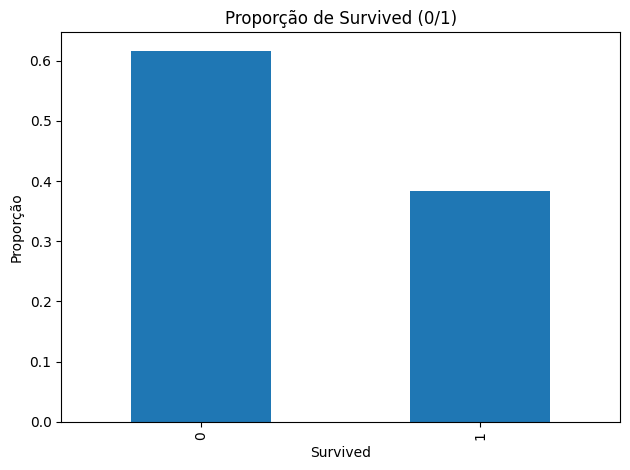

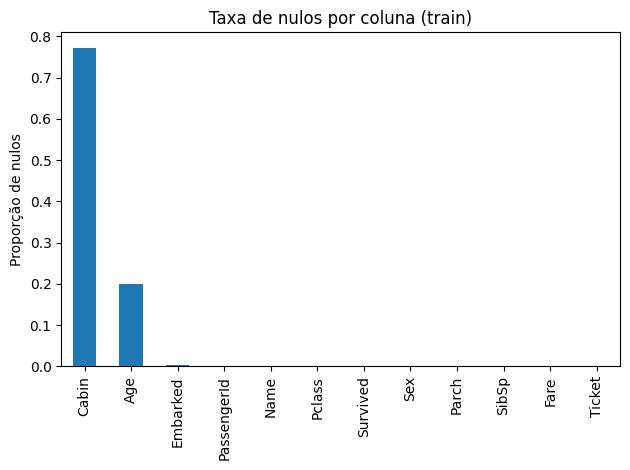

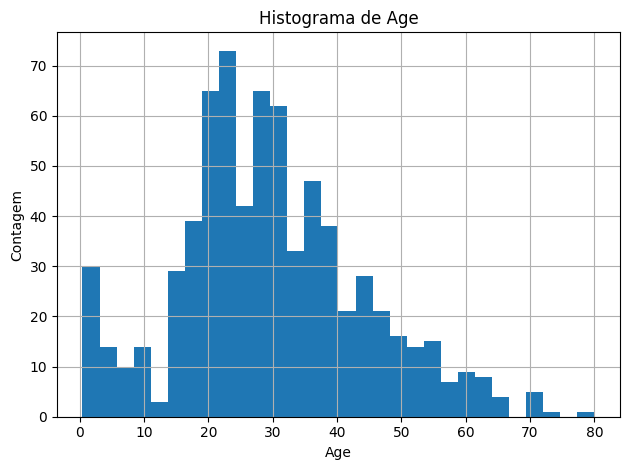

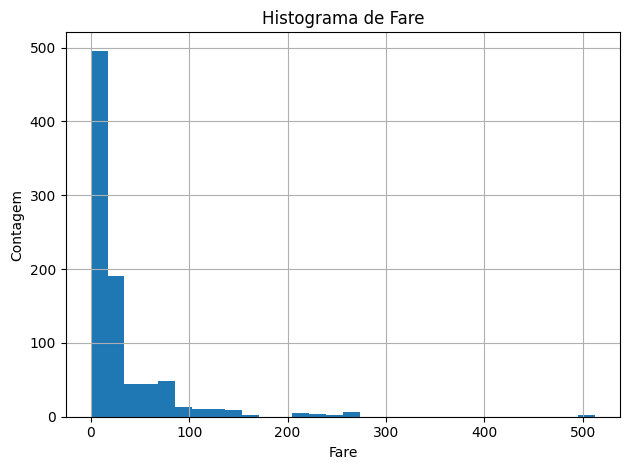

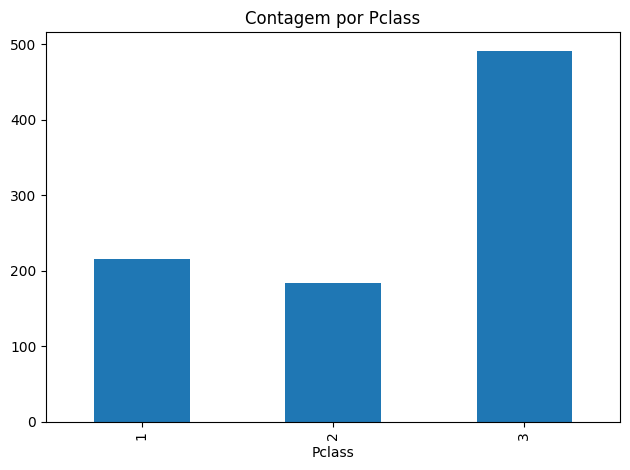

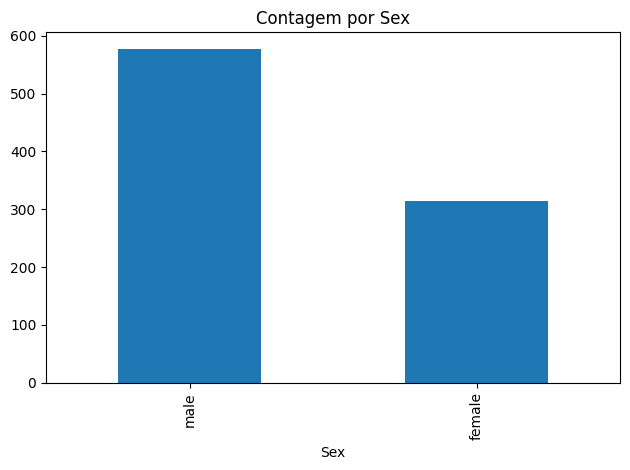

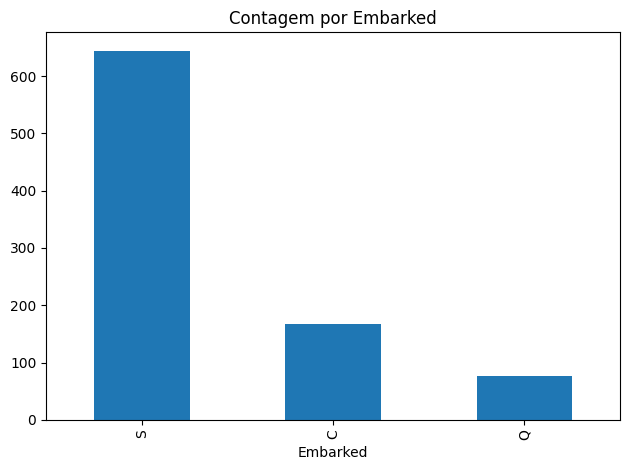

In [7]:
# Info geral para ver tipos e nulos rapidamente
print(df_train.info())

# Estatísticas por coluna (incluo objetos para contar categorias distintas etc.)
display(df_train.describe(include='all').T)

# 2.1 Distribuição do alvo Survived
(ax := df_train['Survived'].value_counts(normalize=True).sort_index().plot.bar())
ax.set_title("Proporção de Survived (0/1)"); ax.set_xlabel("Survived"); ax.set_ylabel("Proporção")
plt.tight_layout(); plt.savefig(OUT_FIGS / "dist_survived.png"); plt.show()

# 2.2 Nulos por coluna (proporção)
null_rate = df_train.isna().mean().sort_values(ascending=False)
(ax := null_rate.plot.bar())
ax.set_title("Taxa de nulos por coluna (train)"); ax.set_ylabel("Proporção de nulos")
plt.tight_layout(); plt.savefig(OUT_FIGS / "null_rate_train.png"); plt.show()

# 2.3 Histogramas de Age e Fare (caudas/outliers)
plt.figure(); df_train['Age'].hist(bins=30)
plt.title("Histograma de Age"); plt.xlabel("Age"); plt.ylabel("Contagem")
plt.tight_layout(); plt.savefig(OUT_FIGS / "hist_age.png"); plt.show()

plt.figure(); df_train['Fare'].hist(bins=30)
plt.title("Histograma de Fare"); plt.xlabel("Fare"); plt.ylabel("Contagem")
plt.tight_layout(); plt.savefig(OUT_FIGS / "hist_fare.png"); plt.show()

# 2.4 Contagens por Pclass, Sex, Embarked
plt.figure(); df_train['Pclass'].value_counts().sort_index().plot.bar()
plt.title("Contagem por Pclass"); plt.tight_layout(); plt.savefig(OUT_FIGS / "count_pclass.png"); plt.show()

plt.figure(); df_train['Sex'].value_counts().plot.bar()
plt.title("Contagem por Sex"); plt.tight_layout(); plt.savefig(OUT_FIGS / "count_sex.png"); plt.show()

plt.figure(); df_train['Embarked'].value_counts().plot.bar()
plt.title("Contagem por Embarked"); plt.tight_layout(); plt.savefig(OUT_FIGS / "count_embarked.png"); plt.show()

## 3) Split holdout estratificado (20% validação)
Eu crio uma validação **estratificada** (mantém proporção de `Survived`) para ajustar hiperparâmetros e medir desempenho.  
Detalhe importante: **`PassengerId` e `Survived` não entram como features**.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, valid_idx = next(sss.split(df_train, df_train['Survived']))

train_df = df_train.iloc[train_idx].reset_index(drop=True)
valid_df = df_train.iloc[valid_idx].reset_index(drop=True)

# Separo X e y (features e alvo). Tiro PassengerId (id) e Survived (o alvo) de X.
X_train_raw = train_df.drop(columns=['Survived', 'PassengerId'])
y_train     = train_df['Survived']
X_valid_raw = valid_df.drop(columns=['Survived', 'PassengerId'])
y_valid     = valid_df['Survived']

# No teste só tiro o PassengerId de X
X_test_raw  = df_test.drop(columns=['PassengerId'])

X_train_raw.shape, X_valid_raw.shape, X_test_raw.shape

((712, 10), (179, 10), (418, 10))

## 4) Feature engineering (eu crio sinais úteis)
Eu gero **Title**, **FamilySize**, **IsAlone**, **CabinInitial** (deck), **TicketPrefix** e faço uma winsorização leve em `Age` e `Fare`.  
Objetivo: dar ao modelo pistas mais diretas sobre perfil social, grupo familiar e cabine/rota.

In [9]:
# Garanto que consigo importar os módulos do meu projeto (src/)
import sys
if str(BASE_DIR / "src") not in sys.path:
    sys.path.insert(0, str(BASE_DIR / "src"))

# Importo as funções que eu escrevi no módulo de features
from features.build_features import add_engineered_features, get_feature_lists

# Aplico as transformações em cada split (sempre SEM usar nada do conjunto de teste no treinamento)
X_train_fe = add_engineered_features(X_train_raw)
X_valid_fe = add_engineered_features(X_valid_raw)
X_test_fe  = add_engineered_features(X_test_raw)

# Descubro quais colunas são numéricas e quais são categóricas (após a engenharia)
numeric_features, categorical_features = get_feature_lists(X_train_fe)
numeric_features, categorical_features

(['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize'],
 ['Sex',
  'Pclass',
  'Embarked',
  'CabinInitial',
  'TicketPrefix',
  'Title',
  'IsAlone'])

## 5) Pré-processamento via `ColumnTransformer`
Eu configuro pipelines para:
- **Numéricas**: imputar mediana e padronizar (média 0, desvio 1)  
- **Categóricas**: imputar moda e One-Hot Encoding (com `ignore`)
Tudo isso **dentro** de `Pipeline/ColumnTransformer` para não vazar informação do `valid/test`.

In [10]:
from data.preprocess import build_preprocessor
preprocessor = build_preprocessor(numeric_features, categorical_features, scaler=True)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Fare', 'SibSp', 'Parch',
                                  'FamilySize']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Pclass', 'Embarked', 'CabinInitial',
                                  'TicketPrefix', 'Title', 'IsAlone'])])

## 6) Modelagem com `Pipeline` e validação cruzada
Agora eu conecto `preprocessor` → `modelo` e comparo três modelos: **LogisticRegression**, **RandomForest**, **GradientBoosting**.  
Eu avalio com CV estratificada e várias métricas (quero olhar além de accuracy).

In [11]:
from models.modeling import build_pipelines, evaluate_pipelines

# Crio um pipeline por modelo (sempre preprocessor antes do estimador)
pipes = build_pipelines(preprocessor)

# Uso train+valid juntos para a CV (apenas para comparar modelos de forma estável)
res_cv = evaluate_pipelines(pipes, pd.concat([X_train_fe, X_valid_fe]), pd.concat([y_train, y_valid]), n_splits=5)
res_cv

,model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
0,logreg,0.827173,0.018804,0.788305,0.024745,0.751492,0.027465,0.769416,0.025654,0.812902,0.020304
1,rf,0.820444,0.020543,0.772710,0.031170,0.754348,0.028513,0.763258,0.027659,0.807991,0.021677
2,gb,0.823784,0.020051,0.794887,0.038536,0.730946,0.022439,0.761183,0.025331,0.806290,0.019404


## 7) Busca de hiperparâmetros (GridSearchCV pequeno e objetivo)
Eu rodo *grid search* com espaços pequenos, otimizando **ROC AUC**.  
Depois escolho o melhor modelo pelo maior ROC AUC médio.

In [12]:
from models.modeling import small_param_grids, run_grid_search

grids = small_param_grids()
best_models = {}
best_scores = {}

for name, pipe in pipes.items():
    print(f"\n>>> Rodando GridSearch para: {name}")
    gs = run_grid_search(pipe, grids[name], X_train_fe, y_train, n_splits=5)
    best_models[name] = gs.best_estimator_
    best_scores[name] = gs.best_score_
    print("Melhor ROC AUC:", gs.best_score_)
    print("Melhores params:", gs.best_params_)

best_scores


>>> Rodando GridSearch para: logreg
Melhor ROC AUC: 0.8726629803784975
Melhores params: {'clf__C': 0.5, 'clf__class_weight': None, 'clf__penalty': 'l2'}

>>> Rodando GridSearch para: rf
Melhor ROC AUC: 0.8845670788343203
Melhores params: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}

>>> Rodando GridSearch para: gb
Melhor ROC AUC: 0.8968295283028827
Melhores params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 200}


{'logreg': np.float64(0.8726629803784975),
 'rf': np.float64(0.8845670788343203),
 'gb': np.float64(0.8968295283028827)}

### Campeão escolhido
Aqui eu pego o nome do modelo com maior ROC AUC e guardo o pipeline completo vencedor.

In [13]:
best_name = max(best_scores, key=best_scores.get)
best_estimator = best_models[best_name]
print("Melhor modelo:", best_name)
best_estimator

Melhor modelo: gb


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch', 'FamilySize']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Pclass', 'Embarked',
                                                   'CabinInitial',
                                                   'TicketPrefix', 'Title',
                                                   'IsAlone'])])),
                ('clf',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=200,
                                            random_state=42))])

## 8) Interpretação — o que pesou nas decisões do modelo?
O que eu vou olhar: **importância de features** (Top 20).  
- Se for linear, uso |coeficiente|.  
- Se for árvore/ensemble, uso `feature_importances_`.  
Isso **não é causalidade**, é só sinal do que o modelo mais usou para separar classes.

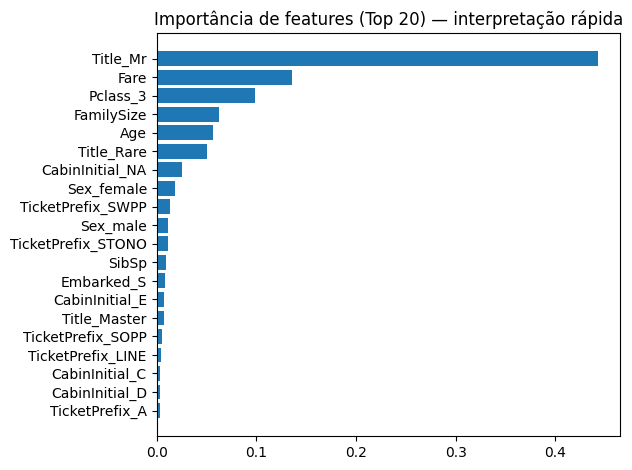

In [14]:
from models.modeling import get_feature_names_from_preprocessor
import numpy as np

# Reajusto o campeão em train+valid para obter importâncias mais estáveis
X_full = pd.concat([X_train_fe, X_valid_fe]).reset_index(drop=True)
y_full = pd.concat([y_train, y_valid]).reset_index(drop=True)
best_estimator.fit(X_full, y_full)

# Extraio os nomes de features depois do preprocessor (inclui colunas OHE)
feature_names = get_feature_names_from_preprocessor(best_estimator.named_steps['pre'])

# Tento coletar importâncias
clf = best_estimator.named_steps['clf']
if hasattr(clf, "coef_"):
    importances = np.abs(clf.coef_).ravel()
elif hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
else:
    importances = None

if importances is not None:
    order = np.argsort(importances)[::-1][:20]  # pego Top 20
    plt.figure()
    plt.barh([feature_names[i] for i in order][::-1], importances[order][::-1])
    plt.title("Importância de features (Top 20) — interpretação rápida")
    plt.tight_layout(); plt.savefig(OUT_FIGS / "feature_importances_top20.png"); plt.show()
else:
    print("Esse modelo não expõe importâncias diretamente. Tudo bem.")

## 9) Avaliação de verdade (com validação) — o que eu vou ver
Eu quero ver a **qualidade do ranking de probabilidades** (ROC/PR),  
a **qualidade do classificador** com um **threshold** (matriz de confusão, métricas),  
e entender a **calibração** (se as probabilidades "acreditam" certo).  
Também vou inspecionar **thresholds** diferentes, **importância por permutação**,  
**partial dependence** (efeito marginal) e **viés por segmento**.

### 9.1 Curvas ROC e Precision-Recall (o que eu espero ver)
- ROC AUC perto de 1 é ótimo; perto de 0.5 é aleatório.  
- PR é útil quando a classe positiva é mais rara (olho o **AP**).  
Se meu modelo estiver razoável, eu devo ver curvas acima das diagonais de referência.

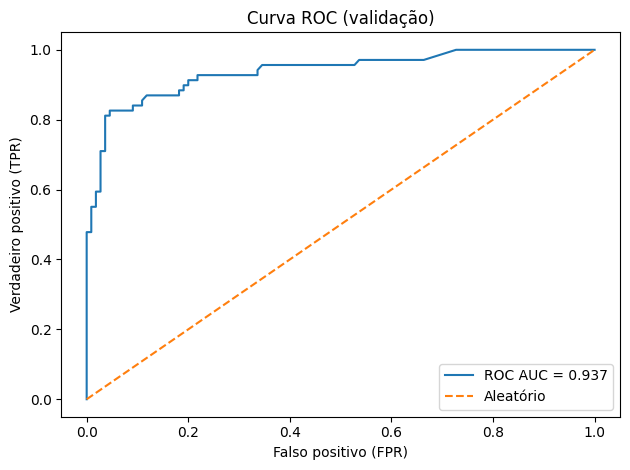

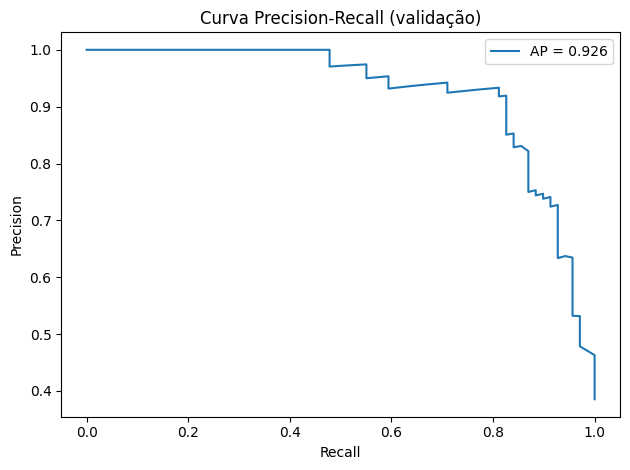

In [15]:
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve

# Função utilitária que sempre me devolve "prob de classe positiva"
def _proba(est, X):
    if hasattr(est.named_steps['clf'], "predict_proba"):
        return est.predict_proba(X)[:, 1]
    elif hasattr(est.named_steps['clf'], "decision_function"):
        # normalizo a decision_function para 0..1 só pra comparar
        from sklearn.preprocessing import MinMaxScaler
        s = est.decision_function(X).reshape(-1,1)
        return MinMaxScaler().fit_transform(s).ravel()
    else:
        return est.predict(X).astype(float)

y_valid_proba = _proba(best_estimator, X_valid_fe)

# ROC
fpr, tpr, _ = roc_curve(y_valid, y_valid_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', label="Aleatório")
plt.xlabel("Falso positivo (FPR)"); plt.ylabel("Verdadeiro positivo (TPR)")
plt.title("Curva ROC (validação)"); plt.legend(); plt.tight_layout()
plt.savefig(OUT_FIGS / "roc_curve_valid.png"); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_valid, y_valid_proba)
ap = average_precision_score(y_valid, y_valid_proba)
plt.figure()
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Curva Precision-Recall (validação)"); plt.legend(); plt.tight_layout()
plt.savefig(OUT_FIGS / "pr_curve_valid.png"); plt.show()

### 9.2 Matriz de confusão + relatório (threshold 0.5)
Aqui eu vejo a troca entre **acertar positivos** (TP) e **evitar falsos positivos** (FP).  
Se eu precisar priorizar **recall** (não perder sobreviventes), posso depois mexer no threshold.

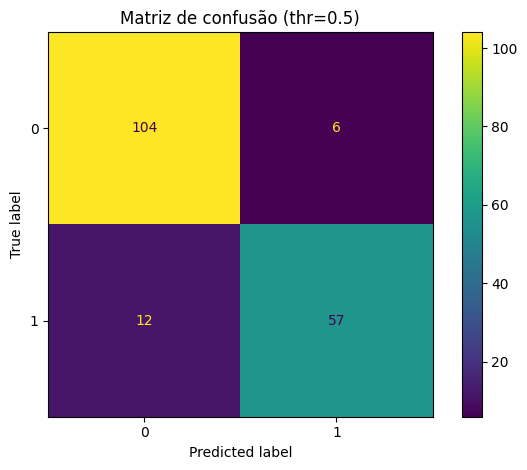

              precision    recall  f1-score   support

           0      0.897     0.945     0.920       110
           1      0.905     0.826     0.864        69

    accuracy                          0.899       179
   macro avg      0.901     0.886     0.892       179
weighted avg      0.900     0.899     0.898       179



In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_valid_pred = (y_valid_proba >= 0.5).astype(int)

cm = confusion_matrix(y_valid, y_valid_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format="d")
plt.title("Matriz de confusão (thr=0.5)"); plt.tight_layout()
plt.savefig(OUT_FIGS / "confusion_matrix_thr05.png"); plt.show()

print(classification_report(y_valid, y_valid_pred, digits=3))

### 9.3 Explorando thresholds (o que acontece se eu mexer no 0.5?)
Eu vario o limiar de decisão e vejo **F1**, **precision**, **recall**, **accuracy**.  
Se eu quisesse "salvar mais gente", eu subiria o **recall** (normalmente ajustando o threshold para baixo).

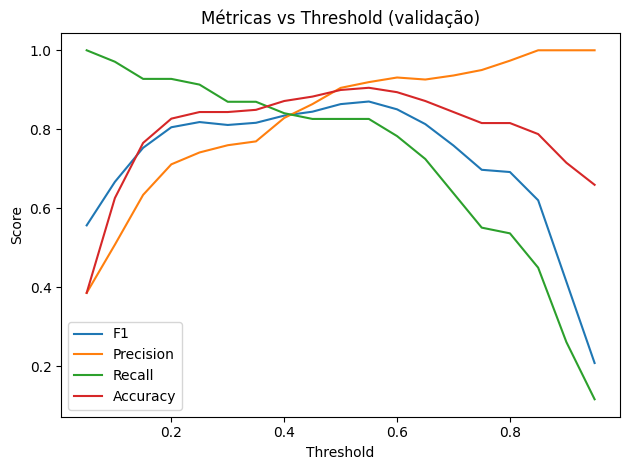

Threshold que maximizou F1: 0.55


In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
import numpy as np

thr_list = np.linspace(0.05, 0.95, 19)
rows = []
for thr in thr_list:
    yhat = (y_valid_proba >= thr).astype(int)
    rows.append({
        "thr": float(thr),
        "f1": f1_score(y_valid, yhat),
        "precision": precision_score(y_valid, yhat),
        "recall": recall_score(y_valid, yhat),
        "accuracy": accuracy_score(y_valid, yhat)
    })
df_thr = pd.DataFrame(rows)

plt.figure()
plt.plot(df_thr["thr"], df_thr["f1"], label="F1")
plt.plot(df_thr["thr"], df_thr["precision"], label="Precision")
plt.plot(df_thr["thr"], df_thr["recall"], label="Recall")
plt.plot(df_thr["thr"], df_thr["accuracy"], label="Accuracy")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("Métricas vs Threshold (validação)")
plt.legend(); plt.tight_layout(); plt.savefig(OUT_FIGS / "metrics_vs_threshold.png"); plt.show()

best_thr = float(df_thr.iloc[df_thr["f1"].idxmax()]["thr"])
print(f"Threshold que maximizou F1: {best_thr:.2f}")

### 9.4 Calibração (as probabilidades fazem sentido?)
Eu comparo probabilidade prevista × fração real de positivos.  
- Se a curva segue a diagonal, as probabilidades estão **bem calibradas**.
- O **Brier score** mede o erro quadrático das probabilidades (quanto menor, melhor).

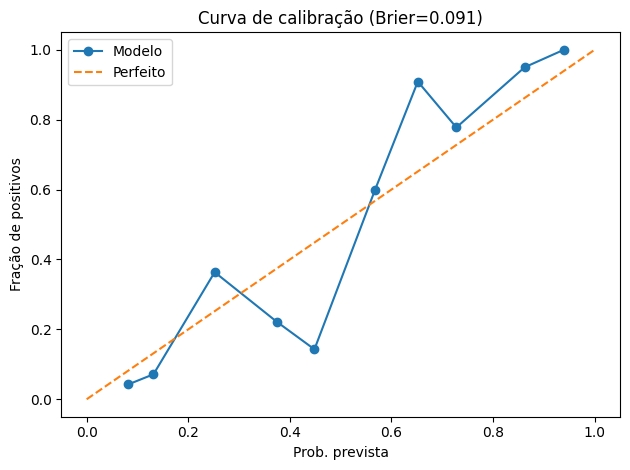

In [18]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob_true, prob_pred = calibration_curve(y_valid, y_valid_proba, n_bins=10, strategy="uniform")
brier = brier_score_loss(y_valid, y_valid_proba)
plt.figure()
plt.plot(prob_pred, prob_true, marker="o", label="Modelo")
plt.plot([0,1],[0,1],"--", label="Perfeito")
plt.xlabel("Prob. prevista"); plt.ylabel("Fração de positivos")
plt.title(f"Curva de calibração (Brier={brier:.3f})")
plt.legend(); plt.tight_layout(); plt.savefig(OUT_FIGS / "calibration_curve.png"); plt.show()

### 9.5 Importância por permutação (robusta e comparável)
Eu embaralho uma coluna por vez e vejo quanto o desempenho piora.  
Se piora muito, aquela feature era importante para o modelo.

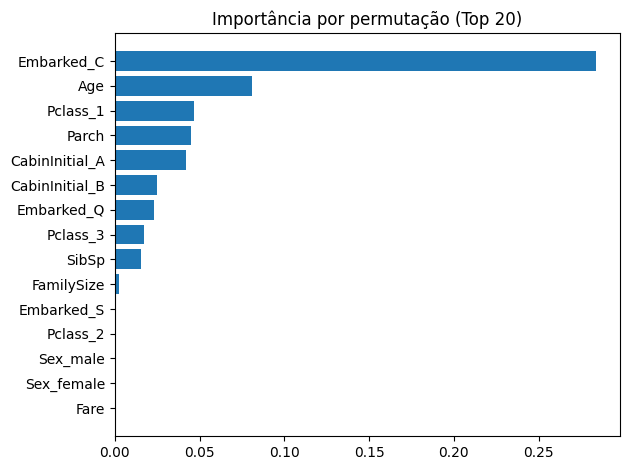

In [19]:
from sklearn.inspection import permutation_importance
from models.modeling import get_feature_names_from_preprocessor
import numpy as np

r = permutation_importance(best_estimator, X_valid_fe, y_valid, n_repeats=10,
                           random_state=RANDOM_STATE, n_jobs=-1, scoring="f1")
fn = np.array(get_feature_names_from_preprocessor(best_estimator.named_steps["pre"]))
idx = np.argsort(r.importances_mean)[-20:]  # Top 20

plt.figure()
plt.barh(fn[idx], r.importances_mean[idx])
plt.title("Importância por permutação (Top 20)")
plt.tight_layout(); plt.savefig(OUT_FIGS / "perm_importances_top20.png"); plt.show()

### 9.6 Partial Dependence (efeito marginal de Age e Fare)
Eu olho o efeito médio de variar **Age** e **Fare**, mantendo o restante nos dados reais.  
Se a curva sobe com `Fare`, por exemplo, indica que tarifas mais altas tendem a aumentar probabilidade de sobrevivência (coerente com Pclass).

<Figure size 640x480 with 0 Axes>

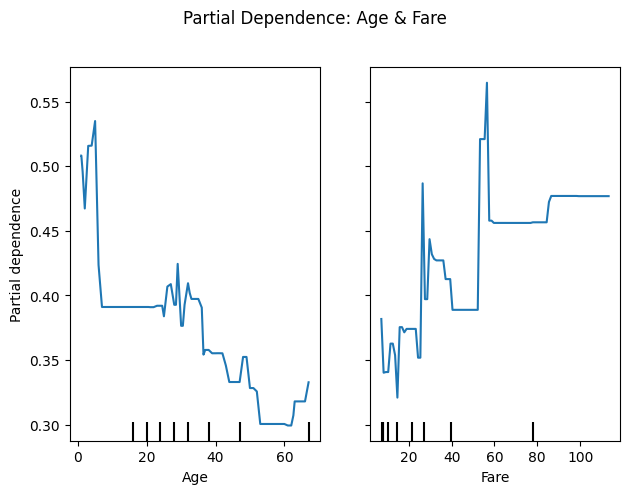

In [20]:
from sklearn.inspection import PartialDependenceDisplay

plt.figure()
PartialDependenceDisplay.from_estimator(best_estimator, X_full, features=["Age", "Fare"])
plt.suptitle("Partial Dependence: Age & Fare", y=1.02)
plt.tight_layout(); plt.savefig(OUT_FIGS / "pdp_age_fare.png"); plt.show()

### 9.7 Viés/segmento (Sex, Pclass)
Eu quebro as métricas por grupos (ex.: **Sex** e **Pclass**).  
Se tiver disparidades claras, eu anoto e penso em mitigações (coletas, features, thresholds por grupo etc.).

In [21]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score

valid_df = valid_df.copy()
valid_df["y_true"] = y_valid.values
valid_df["y_proba"] = y_valid_proba
valid_df["y_pred"] = (y_valid_proba >= 0.5).astype(int)

def segment_report(df, col):
    out = []
    for g, gdf in df.groupby(col):
        # Protejo as métricas caso algum grupo tenha só uma classe
        try: prec = precision_score(gdf["y_true"], gdf["y_pred"])
        except: prec = float("nan")
        try: rec = recall_score(gdf["y_true"], gdf["y_pred"])
        except: rec = float("nan")
        acc = (gdf["y_true"]==gdf["y_pred"]).mean()
        out.append({"grupo": g, "n": len(gdf), "acc": acc, "precision": prec, "recall": rec,
                    "pos_rate_pred": gdf["y_pred"].mean(), "proba_media": gdf["y_proba"].mean()})
    return pd.DataFrame(out).sort_values("n", ascending=False)

print("Por Sex"); display(segment_report(valid_df, "Sex"))
print("Por Pclass"); display(segment_report(valid_df, "Pclass"))

Por Sex


,grupo,n,acc,precision,recall,pos_rate_pred,proba_media
1,male,118,0.898305,1.000000,0.5,0.101695,0.215619
0,female,61,0.901639,0.882353,1.0,0.836066,0.720033


Por Pclass


,grupo,n,acc,precision,recall,pos_rate_pred,proba_media
2,3,100,0.900000,0.791667,0.791667,0.240000,0.256691
0,1,45,0.866667,1.000000,0.760000,0.422222,0.546856
1,2,34,0.941176,0.950000,0.950000,0.588235,0.561394


### 9.8 Casos incertos (próximos de 0.5)
Eu quero olhar manualmente os casos que meu modelo achou **mais duvidosos** (probabilidade ~ 0.5).  
Isso me ajuda a entender onde coletar dados melhores ou criar novas features.

In [22]:
to_review = valid_df.copy()
to_review["dist_0p5"] = (to_review["y_proba"] - 0.5).abs()
cols_show = ["PassengerId","Sex","Pclass","Age","Fare","y_true","y_proba","dist_0p5"]
display(to_review.sort_values("dist_0p5").head(20)[cols_show])

# Se eu quiser salvar os 100 mais incertos:
to_review.sort_values("dist_0p5").head(100)[cols_show].to_csv(OUT_FIGS.parent / "cases_to_review.csv", index=False)

,PassengerId,Sex,Pclass,Age,Fare,y_true,y_proba,dist_0p5
109,246,male,1,44.0,90.0000,0,0.495329,0.004671
7,537,male,1,45.0,26.5500,0,0.488927,0.011073
65,39,female,3,18.0,18.0000,0,0.515714,0.015714
41,298,female,1,2.0,151.5500,0,0.467043,0.032957
87,432,female,3,NaN,16.1000,1,0.563570,0.063570
165,294,female,3,24.0,8.8500,0,0.430740,0.069260
105,24,male,1,28.0,35.5000,1,0.429876,0.070124
60,579,female,3,NaN,14.4583,0,0.570493,0.070493
143,138,male,1,37.0,53.1000,0,0.418408,0.081592
127,800,female,3,30.0,24.1500,0,0.408584,0.091416


### 9.9 Learning curve (vale a pena ter mais dados?)
Eu vejo como a métrica evolui com mais exemplos de treino.  
Se a curva de validação ainda sobe bastante, mais dados podem ajudar.

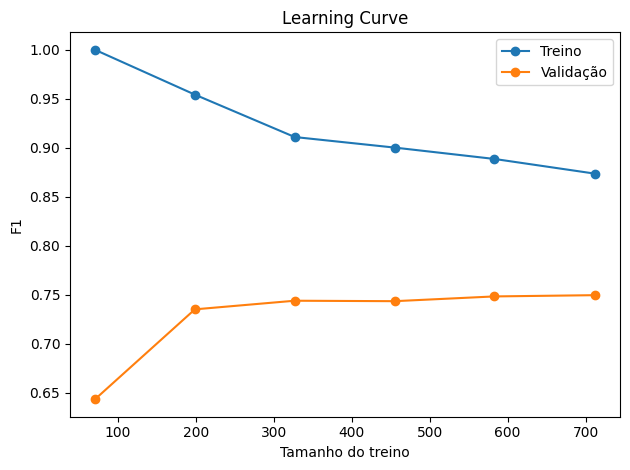

In [23]:
from sklearn.model_selection import learning_curve
import numpy as np

sizes, train_scores, val_scores = learning_curve(best_estimator, X_full, y_full,
                                                 cv=5, scoring="f1",
                                                 train_sizes=np.linspace(0.1, 1.0, 6),
                                                 n_jobs=-1, random_state=RANDOM_STATE)
plt.figure()
plt.plot(sizes, train_scores.mean(axis=1), marker="o", label="Treino")
plt.plot(sizes, val_scores.mean(axis=1), marker="o", label="Validação")
plt.xlabel("Tamanho do treino"); plt.ylabel("F1"); plt.title("Learning Curve")
plt.legend(); plt.tight_layout(); plt.savefig(OUT_FIGS / "learning_curve.png"); plt.show()

## 10) Visualizações de negócio (o que eu espero encontrar)
Agora, além do modelo, eu olho padrões do problema em si.  
- **Sex × Pclass**: grupos com maior taxa de sobrevivência (espera-se mulheres e classes mais altas).
- **FamilySize/IsAlone**: famílias médias podem ter vantagem; sozinho tende a ser pior.
- **CabinInitial** (deck): pode capturar localização no navio; *NA* é muita gente sem cabine registrada.
- **TicketPrefix**: as companhias/rotas podem ter padrões (cuidado: amostras pequenas).

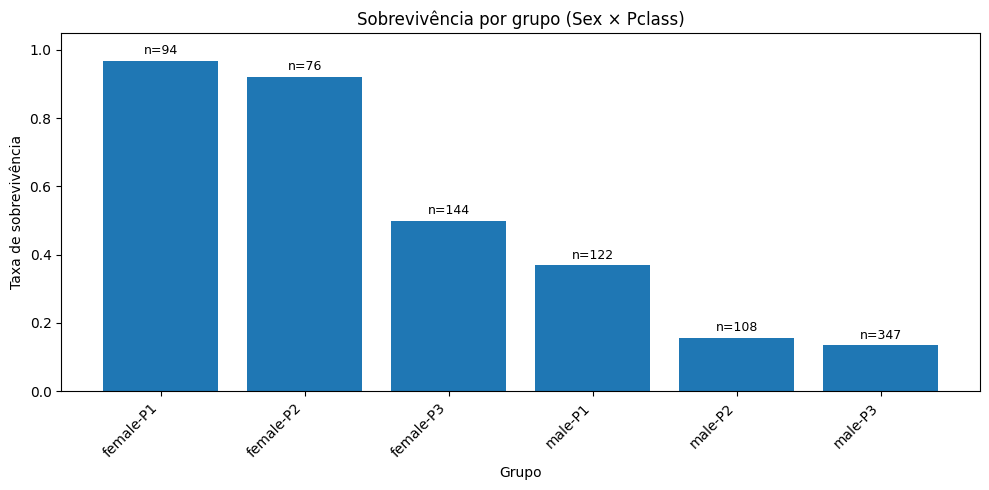

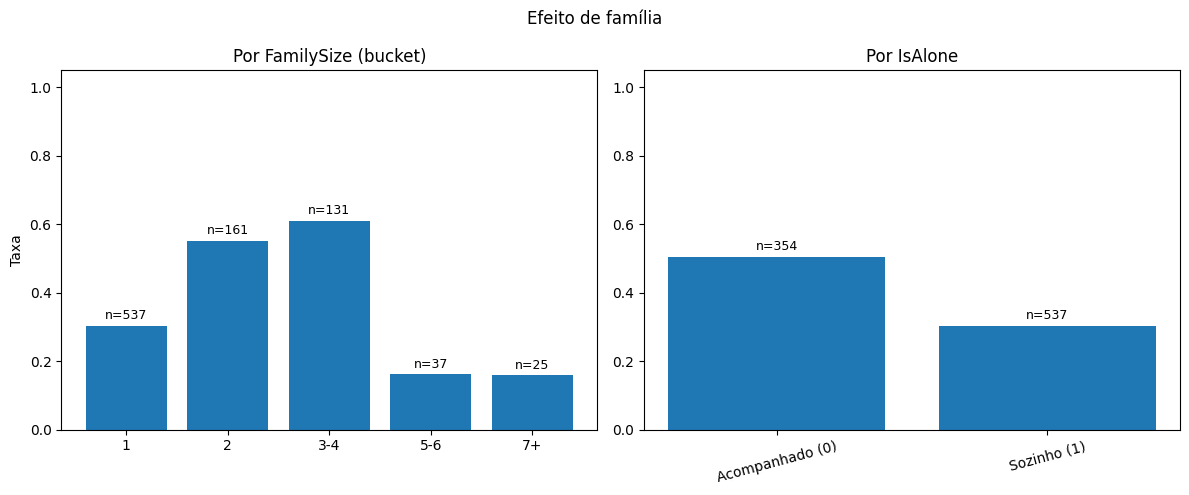

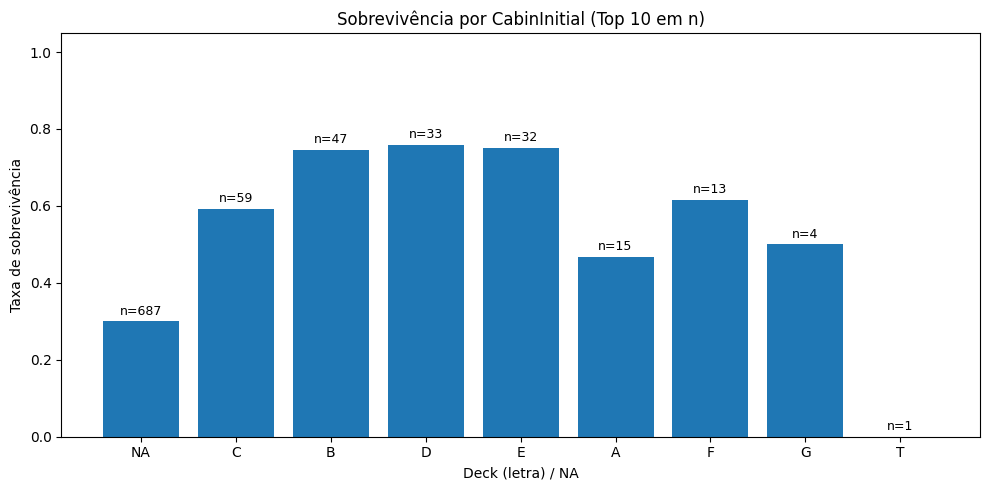

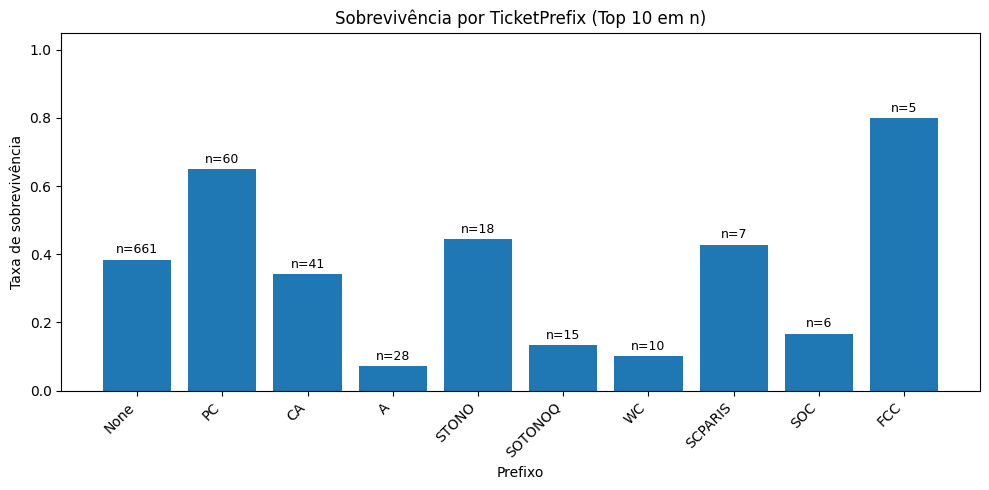

In [24]:
import re
import numpy as np
import pandas as pd

# 10.1 Sex × Pclass
gp = (df_train.groupby(["Sex","Pclass"])["Survived"]
      .agg(["mean","count"])
      .reset_index()
      .sort_values(["Sex","Pclass"]))

labels = [f"{row.Sex}-P{int(row.Pclass)}" for _, row in gp.iterrows()]
rates  = gp["mean"].to_list()
counts = gp["count"].to_list()

x = np.arange(len(labels))
plt.figure(figsize=(10,5))
plt.bar(x, rates)
for i, (r, n) in enumerate(zip(rates, counts)):
    plt.text(i, r + 0.01, f"n={n}", ha="center", va="bottom", fontsize=9)
plt.ylim(0,1.05); plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Taxa de sobrevivência"); plt.xlabel("Grupo")
plt.title("Sobrevivência por grupo (Sex × Pclass)")
plt.tight_layout(); plt.savefig(OUT_FIGS / "survival_by_sex_pclass.png"); plt.show()

# 10.2 FamilySize / IsAlone
tmp = df_train.copy()
tmp["FamilySize"] = tmp["SibSp"].fillna(0) + tmp["Parch"].fillna(0) + 1
tmp["IsAlone"] = (tmp["FamilySize"] == 1).astype(int)

def bucket_family_size(x):
    if x <= 1: return "1"
    if x == 2: return "2"
    if 3 <= x <= 4: return "3-4"
    if 5 <= x <= 6: return "5-6"
    return "7+"

tmp["FamilyBucket"] = tmp["FamilySize"].apply(bucket_family_size)

gp1 = (tmp.groupby("FamilyBucket")["Survived"]
         .agg(["mean","count"])
         .reindex(["1","2","3-4","5-6","7+"]))

labels1 = gp1.index.tolist(); rates1 = gp1["mean"].to_list(); counts1 = gp1["count"].to_list()
plt.figure(figsize=(12,5))
# (a) FamilyBucket
ax1 = plt.subplot(1,2,1)
x1 = np.arange(len(labels1)); ax1.bar(x1, rates1)
for i,(r,n) in enumerate(zip(rates1, counts1)):
    ax1.text(i, r+0.01, f"n={n}", ha="center", va="bottom", fontsize=9)
ax1.set_ylim(0,1.05); ax1.set_xticks(x1, labels1); ax1.set_title("Por FamilySize (bucket)"); ax1.set_ylabel("Taxa")
# (b) IsAlone
gp2 = tmp.groupby("IsAlone")["Survived"].agg(["mean","count"]).reset_index().sort_values("IsAlone")
labels2 = ["Acompanhado (0)","Sozinho (1)"]; rates2 = gp2["mean"].to_list(); counts2 = gp2["count"].to_list()
ax2 = plt.subplot(1,2,2)
x2 = np.arange(len(labels2)); ax2.bar(x2, rates2)
for i,(r,n) in enumerate(zip(rates2, counts2)):
    ax2.text(i, r+0.01, f"n={n}", ha="center", va="bottom", fontsize=9)
ax2.set_ylim(0,1.05); ax2.set_xticks(x2, labels2, rotation=15); ax2.set_title("Por IsAlone")
plt.suptitle("Efeito de família"); plt.tight_layout(); plt.savefig(OUT_FIGS / "family_effect.png"); plt.show()

# 10.3 CabinInitial
tmp = df_train.copy()
tmp["CabinInitial"] = tmp["Cabin"].astype(str).str[0]
tmp.loc[tmp["Cabin"].isna() | (tmp["Cabin"]==""), "CabinInitial"] = "NA"

gp = (tmp.groupby("CabinInitial")["Survived"]
        .agg(["mean","count"])
        .sort_values("count", ascending=False)).head(10)

labels = gp.index.tolist(); rates = gp["mean"].to_list(); counts = gp["count"].to_list()
x = np.arange(len(labels))
plt.figure(figsize=(10,5))
plt.bar(x, rates)
for i,(r,n) in enumerate(zip(rates, counts)):
    plt.text(i, r+0.01, f"n={n}", ha="center", va="bottom", fontsize=9)
plt.ylim(0,1.05); plt.xticks(x, labels); plt.xlabel("Deck (letra) / NA"); plt.ylabel("Taxa de sobrevivência")
plt.title("Sobrevivência por CabinInitial (Top 10 em n)")
plt.tight_layout(); plt.savefig(OUT_FIGS / "survival_by_cabininitial_top10.png"); plt.show()

# 10.4 TicketPrefix
def ticket_prefix(s):
    if not isinstance(s, str): return "None"
    s2 = re.sub(r"[./]", "", s).strip()
    m = re.match(r"([A-Za-z]+)", s2)
    return m.group(1) if m else "None"

tmp = df_train.copy()
tmp["TicketPrefix"] = tmp["Ticket"].apply(ticket_prefix)

gp = (tmp.groupby("TicketPrefix")["Survived"]
        .agg(["mean","count"])
        .sort_values("count", ascending=False)).head(10)

labels = gp.index.tolist(); rates = gp["mean"].to_list(); counts = gp["count"].to_list()
x = np.arange(len(labels))
plt.figure(figsize=(10,5))
plt.bar(x, rates)
for i,(r,n) in enumerate(zip(rates, counts)):
    plt.text(i, r+0.01, f"n={n}", ha="center", va="bottom", fontsize=9)
plt.ylim(0,1.05); plt.xticks(x, labels, rotation=45, ha="right"); plt.xlabel("Prefixo"); plt.ylabel("Taxa de sobrevivência")
plt.title("Sobrevivência por TicketPrefix (Top 10 em n)")
plt.tight_layout(); plt.savefig(OUT_FIGS / "survival_by_ticketprefix_top10.png"); plt.show()

## 11) Geração do `submission.csv`
Eu já tenho o **melhor pipeline ajustado** (no passo 8).  
Agora eu gero as probabilidades no `test`, aplico o threshold 0.5 e salvo `PassengerId,Survived`.

In [25]:
# Pego probabilidade de classe positiva do conjunto de teste
if hasattr(best_estimator.named_steps['clf'], 'predict_proba'):
    test_proba = best_estimator.predict_proba(X_test_fe)[:, 1]
elif hasattr(best_estimator.named_steps['clf'], 'decision_function'):
    from sklearn.preprocessing import MinMaxScaler
    s = best_estimator.decision_function(X_test_fe).reshape(-1,1)
    test_proba = MinMaxScaler().fit_transform(s).ravel()
else:
    test_proba = best_estimator.predict(X_test_fe).astype(float)

# Aplico threshold 0.5 (poderia ajustar com base no que vi em 9.3)
test_pred = (test_proba >= 0.5).astype(int)

# Monto o DataFrame no formato que o Kaggle pede
submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": test_pred
})
submission.to_csv(SUBMISSION_PATH, index=False)
print("Submission salva em:", SUBMISSION_PATH)
submission.head()

Submission salva em: C:\Projetos\machine-learning-projects\titanic-survival-prediction\outputs\submission.csv


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## 12) Salvar o melhor modelo (reuso futuramente)
Eu salvo o pipeline completo (pré-processamento + modelo). Assim, ao carregar, é só dar `predict`.

In [ ]:
from joblib import dump
model_path = OUT_MODELS / "model.joblib"
dump(best_estimator, model_path)
print("Modelo salvo em:", model_path)

Modelo salvo em: C:\Projetos\machine-learning-projects\titanic-survival-prediction\outputs\models\model.joblib


: 